In [82]:
# -- IMPORTING PACKAGES --
using JuMP, BilevelJuMP, Gurobi
using MultiJuMP
import MultiObjectiveAlgorithms as MOA
using HiGHS
using Plots
using LaTeXStrings

In [116]:
# -- Code to solve the example of Dempe (2002), Chapter 3.2, Page 25 --
model = BilevelModel(Gurobi.Optimizer, mode=BilevelJuMP.SOS1Mode()) 
@variable(Upper(model), x)
@variable(Lower(model), y) 

@objective(Upper(model), Min,  3y + 0.2x) # convex objective function

@constraints(Upper(model), begin
     x <= 5
     x >= 1
end)

@objective(Lower(model), Min, -y) 

@constraints(Lower(model), begin
     y + 0.5x <= 7
     4y - x >= 5
     2y - x <= 10
     y >= 0
end)
# sur le graphe geogebra FED est le feasible set
optimize!(model)
upper_obj_sol = objective_value(Upper(model)) # = 3 * (3.5 * 8/15) + 8/15
lower_obj_sol = objective_value(Lower(model))
println(upper_obj_sol)
println(lower_obj_sol)
println(value(x)) # = 3.5 * 8/15
println(value(y)) # = 8/15

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 11 rows, 10 columns and 24 nonzeros
Model fingerprint: 0xd4efa449
Model has 4 SOS constraints
Variable types: 10 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [5e-01, 4e+00]
  Objective range  [2e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 8 rows and 3 columns
Presolve time: 0.00s
Presolved: 3 rows, 7 columns, 9 nonzeros
Presolved model has 3 SOS constraint(s)
Variable types: 7 continuous, 0 integer (0 binary)

Root relaxation: objective 4.700000e+00, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap 

In [152]:
import Plots
model = JuMP.Model(() -> MOA.Optimizer(HiGHS.Optimizer))
#set_optimizer_attribute(model, MOA.Algorithm(), MOA.Dichotomy())
set_optimizer_attribute(model, MOA.Algorithm(), MOA.EpsilonConstraint())
@variable(model, y)
@variable(model, x) 

@constraints(model, begin
    # Upper level constraints
    x <= 5
    x >= 1
    # Lower level constraints
    y + 0.5x <= 7
    4y - x >= 5
    2y - x <= 10
    y >= 0
end)

# objectives
@expression(model, upper_obj, 3y + 0.2x)
@expression(model, lower_obj,  -y)
@objective(model, Min, [upper_obj, lower_obj])

optimize!(model)
# for i in 1:result_count(model)
#     println("Solution $i")
#     println("   x = ", value.([x, y]; result = i))
#     println(" obj = ", objective_value(model; result = i))
# end

#, MOA.ObjectiveWeight(1) -> 1.0,  MOA.ObjectiveWeight(2) -> 1.0)
#set_attribute(model, MOA.SolutionLimit(), 4)
# result_count(model)
println("number of solutions : $(result_count(model))")
colors = ["#689BAA", "#C2C5DB"]
fig = Plots.scatter(
    [value(upper_obj; result = i) for i in 1:result_count(model)],
    [value(lower_obj; result = i) for i in 1:result_count(model)];
    xlabel = L"F(x,y)",
    ylabel = L"f(x,y)",
    title = "",
    label = "Pareto Optimal Solutions",
    markercolor="#689BAA",
    markerstrokecolor="#3E5D66",
    markersize=7,
    #markerstrokecolor="#689BAA",
    grid=true,
    markerstrokewidth=3,
    guidefontsize=18,
    tickfontsize=16,
    #xlims = (915, 960),
)


# for i in 1:result_count(model)
#     y = objective_value(model; result = i)
#     Plots.annotate!(fig, y[1] - 1, y[2], (i, 10))
# end
# ideal_point = objective_bound(model)
# Plots.scatter!(fig, [ideal_point[1]], [ideal_point[2]]; label = "Ideal point")


# ------------------ Solving with a weighted sum with equal weight: ---------
simple_model = Model(Gurobi.Optimizer)
#set_optimizer_attribute(simple_model, "PoolSearchMode", 2)
#set_optimizer_attribute(simple_model, "PoolSolutions", 100)
@variable(simple_model, y)
@variable(simple_model, x) 

@constraints(simple_model, begin
     # Upper level constraints
     x <= 5
     x >= 1
     # Lower level constraints
     y + 0.5x <= 7
     4y - x >= 5
     2y - x <= 10
     y >= 0
end)

# objectives
@objective(simple_model, Min,  (3y + 0.2x) - y)
optimize!(simple_model)

scatter!(fig,
    [upper_obj_sol], [lower_obj_sol],
    labels="Bilevel Solution", markercolor=:red, markerstrokecolor=:red, markerstrokewidth=3, markersize=7, markershape= :xcross		
	)
scatter!(fig,
    [value(3y + 0.2x)], [value(-y)],
    labels="Weighted-Sum Solution with  "*L"w_1=1, w_2=1", markercolor=:grey89, markerstrokecolor=:black, markerstrokewidth=3, markersize=7, markershape=:hexagon		
	)
@objective(simple_model, Min,  (3y + 0.2x) - 4y)
    optimize!(simple_model)

scatter!(fig,
    [value(3y + 0.2x)], [value(-y)],
    labels="Weighted-sum Solution with  "*L"w_1=1, w_2=4", markercolor=:grey89, markerstrokecolor=:brown, markerstrokewidth=3, markersize=7, markershape=:hexagon			
	)
savefig(fig, "/Users/manoncornet/Documents/University/TFE/ThesisWriting/Master_Thesis/images/ToyExampleSolution.pdf")

Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
3 rows, 2 cols, 6 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-6); columns 0(-2); elements 0(-9) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  4.7000000000e+00
HiGHS run time      :          0.00
Solving LP without presolve or with basis
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -5.0000000000e-01 Ph1: 3(3.7); Du: 2(0.5) 0s
          1    -1.5000000000e+00 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 1
Objective value     : -1.5000000000e+00
HiGHS run time      :          0.00
Presolving model
3 rows, 2 cols, 6 nonzeros
3 rows, 2 cols, 6 nonzeros
Presolve : Reductions: rows 3(-3); columns 2(-0); elements 6(-3)
Solving the presolved LP
Using EKK dual simplex solver - seria

"/Users/manoncornet/Documents/University/TFE/ThesisWriting/Master_Thesis/images/ToyExampleSolution.pdf"

In [148]:
"l"+"hello"

LoadError: MethodError: no method matching +(::String, ::String)
String concatenation is performed with [36m*[39m (See also: https://docs.julialang.org/en/v1/manual/strings/#man-concatenation).

[0mClosest candidates are:
[0m  +(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m)
[0m[90m   @[39m [90mBase[39m [90m[4moperators.jl:578[24m[39m
[0m  +([91m::Union{MathOptInterface.VariableIndex, MathOptInterface.ScalarAffineFunction{T}, MathOptInterface.ScalarQuadraticFunction{T}}[39m, ::T) where T
[0m[90m   @[39m [35mMathOptInterface[39m [90m~/.julia/packages/MathOptInterface/864xP/src/Utilities/[39m[90m[4mfunctions.jl:1330[24m[39m
[0m  +([91m::MutableArithmetics.Zero[39m, ::Any)
[0m[90m   @[39m [36mMutableArithmetics[39m [90m~/.julia/packages/MutableArithmetics/h0wjj/src/[39m[90m[4mrewrite.jl:56[24m[39m
[0m  ...


Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 7 rows, 2 columns and 12 nonzeros
Model fingerprint: 0x662e00d1
Coefficient statistics:
  Matrix range     [2e-01, 3e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+00]
Presolve removed 2 rows and 0 columns
Presolve time: 0.00s
Presolved: 5 rows, 2 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3256667e+00   6.137583e+00   0.000000e+00      0s
       2    5.2500000e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds (0.00 work units)
Optimal objective  5.250000000e+00

User-callback calls 45, time in user-callback 0.00 sec
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (ma

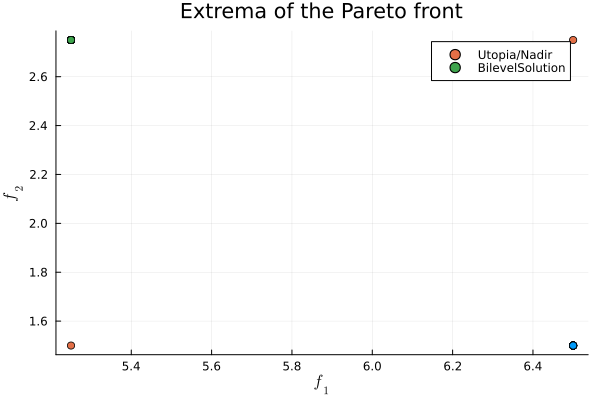

In [6]:
# -- MultiJuMP support version --
model = multi_model(Gurobi.Optimizer, linear = true)
@variable(model, x)
@variable(model, y) 

@constraints(model, begin
    # Upper level constraints
    x >= 0
    # Lower level constraints
    y >= -x + 4
    y <= 3x - 1
    y <= 0.5x + 3 
    y <= -0.5x + 7 
    y >= 0.2x + 1
    y >= 0
end)

# objectives
upper_obj = @expression(model, 2x + y)
lower_obj = @expression(model, -y)
obj1 = SingleObjective(upper_obj, sense = MOI.MIN_SENSE)
obj2 = SingleObjective(lower_obj, sense = MOI.MIN_SENSE)

# # setting objectives in the data
multim = get_multidata(model)
multim.objectives = [obj1, obj2]
multim.pointsperdim = 30

#optimize!(model, method = EpsilonCons())
optimize!(model, method = WeightedSum())
println(value.(x))
println(value.(y))

utopiapoint = getutopia(multim)
nadirpoint = getnadir(multim)

using Plots: plot, title!, scatter!
pltlin = plot(multim)
title!(pltlin, "Extrema of the Pareto front")

# Show Utopia and Nadir points
# (This is probably a hacky way to do this)
scatter!(pltlin,
    [utopiapoint[1], nadirpoint[1]], [utopiapoint[2], nadirpoint[2]],
    label="Utopia/Nadir")

scatter!(pltlin,
    [upper_obj_sol], [lower_obj_sol],
    label="BilevelSolution")


# simple_model = Model(Gurobi.Optimizer)
# #set_optimizer_attribute(simple_model, "PoolSearchMode", 2)
# #set_optimizer_attribute(simple_model, "PoolSolutions", 100)
# @variable(simple_model, y)
# @variable(simple_model, x) 

# @constraints(simple_model, begin
#      # Upper level constraints
#      x <= 5
#      y <= 8
#      y >= 0
#      # Lower level constraints
#      x + y <= 8 
#      4x + y >= 8 
#      2x + y <= 13 
#      2x - 7y <= 0 
# end)

# # objectives
# @objective(simple_model, Min, 3x+y)
# optimize!(simple_model)

# scatter!(pltlin,
#      value(3x+y), value.(-x))

In [ ]:

using Test

model = direct_model(Gurobi.Optimizer())

@variable(model, x)
@variable(model, y)

@constraints(model, begin
     # Upper level constraints
     x <= 5
     y <= 8
     y >= 0
     # Lower level constraints
     x + y <= 8 
     4x + y >= 8 
     2x + y <= 13 
     2x - 7y <= 0
end)

@objective(model, Min, 3x + y)
f2 = @expression(model, -x)
MOI.set(model, Gurobi.MultiObjectiveFunction(2), moi_function(f2))

@test MOI.get(model, Gurobi.MultiObjectiveWeight(1)) == 1.0
@test MOI.get(model, Gurobi.MultiObjectiveWeight(2)) == 1.0
@test MOI.get(model, Gurobi.MultiObjectivePriority(1)) == 0
@test MOI.get(model, Gurobi.MultiObjectivePriority(2)) == 0
optimize!(model)

solution_summary(model)
# @expression(model, lower_obj, -x)
# @objective(model, Min, [upper_obj, lower_obj])
# optimize!(model)
# solution_summary(model)


In [ ]:
# EXAMPLE USING MULTILEVEL LIBRARY
mmodel = multi_model(Gurobi.Optimizer, linear = true)
y = @variable(mmodel, 0 <= y <= 10.0)
z = @variable(mmodel, 0 <= z <= 10.0)
@constraint(mmodel, y + z <= 15.0)

# objectives
exp_obj1 = @expression(mmodel, -y +0.05 * z)
exp_obj2 = @expression(mmodel, 0.05 * y - z)
obj1 = SingleObjective(exp_obj1)
obj2 = SingleObjective(exp_obj2)

# # setting objectives in the data
multim = get_multidata(mmodel)
multim.objectives = [obj1, obj2]
multim.pointsperdim = 10
optimize!(mmodel, method = WeightedSum())

using Plots: plot
plot(multim)